In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
import pandas as pd

# Load the labels CSV
image_labels = pd.read_csv('/content/drive/MyDrive/Human+Action+Recognition-20220526T101201Z-001/Human Action Recognition/image_label.csv')



In [ ]:
import os
import tensorflow as tf
import numpy as np
from tqdm import tqdm

# Set the image directory path
image_dir = '/content/drive/MyDrive/Human+Action+Recognition-20220526T101201Z-001/Human Action Recognition/image/'

# List of image paths and corresponding labels
image_paths = [os.path.join(image_dir, fname) for fname in image_labels['filename']]
labels = image_labels['label'].values

# Map the labels to integer values
labels_dict = {label: idx for idx, label in enumerate(image_labels['label'].unique())}
image_labels['label'] = image_labels['label'].map(labels_dict)

# Resize images and prepare the dataset
image_size = (128, 128)  # You can adjust this as needed

# Function to load and preprocess images
def process_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode image
    img = tf.image.resize(img, image_size)  # Resize image
    img = img / 255.0  # Normalize image to [0, 1] range
    return img

# Create a TensorFlow dataset
image_paths_tf = tf.constant(image_paths)
labels_tf = tf.constant(image_labels['label'].values)

# Map the image processing function to the dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths_tf, labels_tf))
dataset = dataset.map(lambda x, y: (process_image(x), y))

# Set up batch processing (for efficiency)
batch_size = 32  # You can adjust this depending on your memory
dataset = dataset.batch(batch_size)

# Optionally, prefetch the data for better performance
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Create a list to store images and labels
images = []
labels = []

# Iterate over the dataset
for img_batch, label_batch in tqdm(dataset, desc="Processing Images", unit="batch"):
    images.append(img_batch.numpy())  # Convert the batch to numpy arrays
    labels.append(label_batch.numpy())

# Concatenate all batches into final arrays
images = np.concatenate(images, axis=0)
labels = np.concatenate(labels, axis=0)

# Save the processed images and labels to a .npz file
np.savez('processed_data_gpu.npz', images=images, labels=labels)
print("Data saved successfully.")


Processing Images:  91%|█████████ | 143/158 [03:08<00:16,  1.09s/batch]

In [4]:
image_labels

,filename,label
0,Image_2.jpg,0
1,Image_4.jpg,1
2,Image_5.jpg,0
3,Image_6.jpg,1
4,Image_11.jpg,2
...,...,...
5035,Image_12584.jpg,4
5036,Image_12586.jpg,2
5037,Image_12589.jpg,2
5038,Image_12592.jpg,0


In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Further split the test set into validation and test sets (if needed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [6]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4032, 128, 128, 3)
y_train shape: (4032,)
X_val shape: (504, 128, 128, 3)
y_val shape: (504,)
X_test shape: (504, 128, 128, 3)
y_test shape: (504,)


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [8]:
# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the base model layers


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = Dense(512, activation='relu')(x)  # Add a dense layer
x = Dropout(0.5)(x)  # Add dropout for regularization
output = Dense(len(labels_dict), activation='softmax')(x)  # Output layer with number of classes

# Combine the base model and the custom layers
model = Model(inputs=base_model.input, outputs=output)


In [10]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32)


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.2024 - loss: 1.8430 - val_accuracy: 0.2897 - val_loss: 1.6829
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3128 - loss: 1.6569 - val_accuracy: 0.3690 - val_loss: 1.6179
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3636 - loss: 1.5864 - val_accuracy: 0.3968 - val_loss: 1.5505
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3832 - loss: 1.5317 - val_accuracy: 0.3750 - val_loss: 1.5343
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4140 - loss: 1.4858 - val_accuracy: 0.4464 - val_loss: 1.4752
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4091 - loss: 1.4634 - val_accuracy: 0.4504 - val_loss: 1.4637
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4371 - loss: 1.4184 - val_accuracy: 0.4187 - val_loss: 1.4701
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4536 - loss: 1.4125 - val_acc

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5226 - loss: 1.3261
Test Accuracy: 49.40%


In [13]:
from tensorflow.keras import layers, models

# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(labels_dict), activation='softmax')  # Number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse if labels are integers
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,414 (12.61 MB)

 Trainable params: 3,305,414 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model on the training set
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32
)


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.2294 - loss: 1.7841 - val_accuracy: 0.4643 - val_loss: 1.3693
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4894 - loss: 1.3278 - val_accuracy: 0.5357 - val_loss: 1.2837
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5945 - loss: 1.0811 - val_accuracy: 0.5456 - val_loss: 1.2384
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6908 - loss: 0.8235 - val_accuracy: 0.5357 - val_loss: 1.2943
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7831 - loss: 0.6185 - val_accuracy: 0.5456 - val_loss: 1.4886
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8460 - loss: 0.4696 - val_accuracy: 0.5655 - val_loss: 1.5048
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9291 - loss: 0.2254 - val_accuracy: 0.5615 - val_loss: 1.8383
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9583 - loss: 0.1360 - val_accu

In [15]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5848 - loss: 3.6786
Test Accuracy: 56.55%


In [35]:
from tensorflow.keras.preprocessing import image # Import the 'image' module from Keras
import numpy as np

# Load and preprocess a new image for prediction
new_image_path = '/content/drive/MyDrive/Human+Action+Recognition-20220526T101201Z-001/Human Action Recognition/image/Image_10.jpg'
img = image.load_img(new_image_path, target_size=image_size) # Now 'image' is defined
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Normalize the image
img_array = img_array / 255.0

# Predict using the model
prediction = model.predict(img_array)

# Get the predicted label
predicted_label = list(labels_dict.keys())[np.argmax(prediction)]
print(f"Predicted label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
Predicted label: sleeping


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


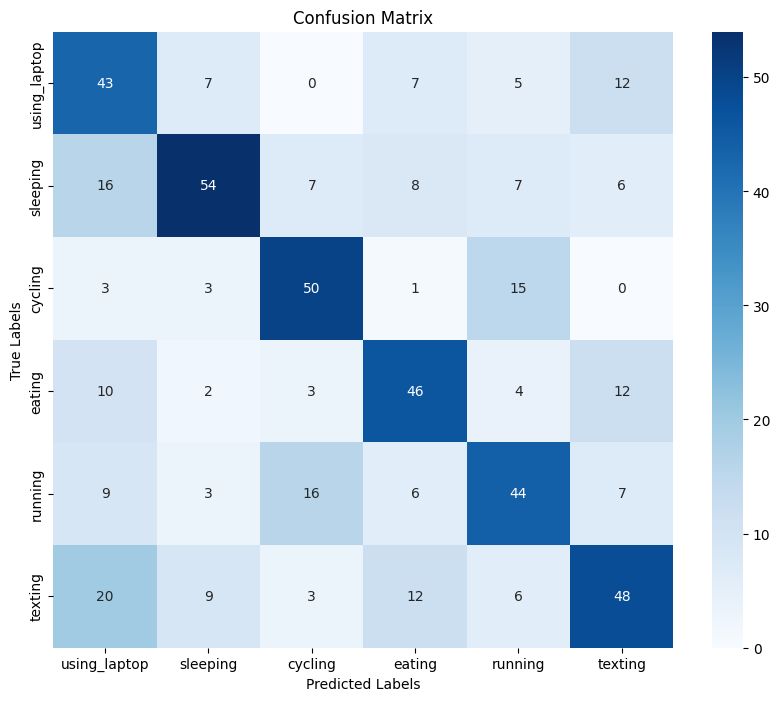

In [20]:
# prompt: generate a confusion matrix for text set

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(labels_dict.keys()), yticklabels=list(labels_dict.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image augmentation transformations
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator on the training set
datagen.fit(X_train)

# Train the model using the augmented data
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val)
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/126 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.2608 - loss: 2.5855 - val_accuracy: 0.2163 - val_loss: 1.7747
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.2273 - loss: 1.7527 - val_accuracy: 0.3036 - val_loss: 1.6757
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.3108 - loss: 1.6608 - val_accuracy: 0.3671 - val_loss: 1.5598
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.3599 - loss: 1.5484 - val_accuracy: 0.3909 - val_loss: 1.4839
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.3970 - loss: 1.4502 - val_accuracy: 0.4444 - val_loss: 1.3160
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.4325 - loss: 1.3733 - val_accuracy: 0.4563 - val_loss: 1.3505
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.4447 - loss: 1.3340 - val_accuracy: 0.4405 - val_loss: 1.4106
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.4749 - loss: 1.2826 - val

In [22]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5797 - loss: 1.0575
Test Accuracy: 59.13%


In [33]:
import numpy as np

# Assuming conf_matrix is your confusion matrix
TP = np.diag(conf_matrix)  # True Positives are the diagonal elements
FP = np.sum(conf_matrix, axis=0) - TP  # False Positives: Column sum - TP
FN = np.sum(conf_matrix, axis=1) - TP  # False Negatives: Row sum - TP

# Avoid division by zero with np.errstate
with np.errstate(divide='ignore', invalid='ignore'):
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    F1_score = 2 * (Precision * Recall) / (Precision + Recall)
    F1_score = np.nan_to_num(F1_score)  # Replace NaN with 0 for undefined scores

# Print F1-score for each class
for i, score in enumerate(F1_score):
    print(f"Class {i} F1-Score: {score:.2f}")


Class 0 F1-Score: 0.49
Class 1 F1-Score: 0.61
Class 2 F1-Score: 0.66
Class 3 F1-Score: 0.59
Class 4 F1-Score: 0.53
Class 5 F1-Score: 0.52


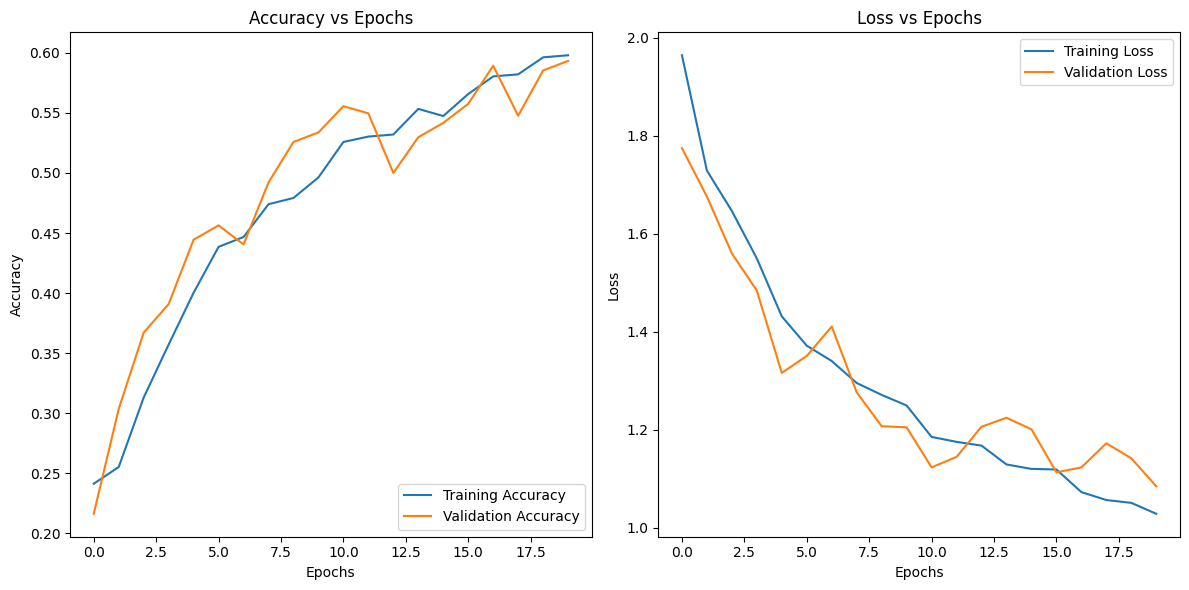

In [34]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by the model's 'fit' method during training
# For example: history = model.fit(...)

# Plotting accuracy and loss curves
def plot_training_history(history):
    # Accuracy Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Example: Assuming you trained the model with `history = model.fit(...)`
# Replace with your model's training history variable
plot_training_history(history)  # Replace 'history' with the actual variable name if different
